# GB-InSAR Rockfall Prediction System

This notebook implements a machine learning-based rockfall prediction system using GB-InSAR data. The system processes displacement measurements, trains predictive models, and provides risk assessments for potential rockfall events.

## System Components
1. Data Collection and Management
2. Data Preprocessing and Feature Engineering
3. Exploratory Data Analysis
4. Model Training (Random Forest & Gradient Boosting)
5. Prediction Pipeline
6. Risk Visualization and Alerts

## 1. Setup and Required Libraries

Import necessary libraries and set up the environment for data processing and analysis.

In [1]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.metrics import accuracy_score, f1_score, r2_score, confusion_matrix
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Create necessary directories
os.makedirs('data', exist_ok=True)
os.makedirs('data/models', exist_ok=True)

# Define file paths
DATA_FILE = 'data/rockfall_data.csv'
PREDICTIONS_FILE = 'data/rockfall_predictions.csv'
RF_MODEL_PATH = 'data/models/random_forest_model.joblib'
GB_MODEL_PATH = 'data/models/gradient_boosting_model.joblib'

## 2. Data Generation and Management

Create synthetic GB-InSAR data for rockfall monitoring or load existing data. The system simulates 2 readings per day with realistic displacement patterns.

In [2]:
def generate_synthetic_data(n_samples=60):
    """
    Generate synthetic GB-InSAR data with realistic patterns.
    """
    data = {
        'timestamp': [],
        'displacement': [],
        'displacement_rate': [],
        'displacement_direction': [],
        'cumulative_displacement': [],
        'displacement_acceleration': [],
        'slope_angle': [],
        'slope_aspect': [],
        'risk_class': [],
        'point_coordinates': [],
        'coverage_area': []
    }
    
    # Generate timestamps (2 readings per day)
    end_date = datetime.now()
    start_date = end_date - timedelta(days=n_samples/2)
    timestamps = []
    current_date = start_date
    while current_date <= end_date:
        timestamps.extend([current_date, current_date + timedelta(hours=12)])
        current_date += timedelta(days=1)
    timestamps = timestamps[:n_samples]
    
    # Generate synthetic measurements
    for i in range(n_samples):
        # Basic displacement pattern with some randomness
        base_displacement = np.random.normal(5, 2)
        displacement_rate = np.random.normal(0.5, 0.2)
        
        data['timestamp'].append(timestamps[i])
        data['displacement'].append(base_displacement)
        data['displacement_rate'].append(displacement_rate)
        data['displacement_direction'].append(np.random.randint(0, 360))
        data['cumulative_displacement'].append(base_displacement * (i/10 + 1))
        data['displacement_acceleration'].append(np.random.normal(0.1, 0.05))
        data['slope_angle'].append(np.random.uniform(30, 80))
        data['slope_aspect'].append(np.random.randint(0, 360))
        
        # Risk class based on displacement and rate
        risk = 'Low' if base_displacement < 4 else 'Medium' if base_displacement < 8 else 'High'
        data['risk_class'].append(risk)
        
        # Random coordinates within a realistic area
        x, y = np.random.uniform(0, 100, 2)
        data['point_coordinates'].append(f"{x:.2f}, {y:.2f}")
        data['coverage_area'].append(np.random.uniform(10, 50))
    
    return pd.DataFrame(data)

def load_or_create_data():
    """
    Load existing data or create new synthetic data if file doesn't exist.
    """
    if os.path.exists(DATA_FILE):
        existing_data = pd.read_csv(DATA_FILE)
        existing_data['timestamp'] = pd.to_datetime(existing_data['timestamp'])
        return existing_data
    else:
        new_data = generate_synthetic_data()
        new_data.to_csv(DATA_FILE, index=False)
        return new_data

# Load or generate initial data
df = load_or_create_data()
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (60, 11)


,timestamp,displacement,displacement_rate,displacement_direction,cumulative_displacement,displacement_acceleration,slope_angle,slope_aspect,risk_class,point_coordinates,coverage_area
0,2025-09-18 10:25:41.506095,5.993428,0.472347,106,5.993428,0.123693,52.291638,214,Medium,"5.81, 86.62",34.044600
1,2025-09-18 22:25:41.506095,7.736900,0.383824,276,8.510590,0.073742,60.874075,313,Medium,"52.48, 43.19",21.649166
2,2025-09-19 10:25:41.506095,2.974338,0.562849,187,3.569205,0.064833,69.258798,50,Low,"38.25, 98.32",28.670516
3,2025-09-19 22:25:41.506095,0.720759,0.583402,328,0.936986,0.141623,33.252580,88,Low,"96.56, 80.84",22.184551
4,2025-09-20 10:25:41.506095,5.582068,0.372888,263,7.814895,0.141127,45.585554,53,Medium,"54.67, 18.49",48.783385


## 3. Data Preprocessing and Feature Engineering

Prepare the data for analysis by handling missing values, scaling numerical features, and creating derived features.

In [12]:
# Preprocess data and engineer features
def preprocess_data(df):
    """
    Preprocess the data and engineer new features.
    """
    # Create a copy to avoid modifying original data
    processed_df = df.copy()
    
    # Handle missing values
    numeric_columns = ['displacement', 'displacement_rate', 'cumulative_displacement', 
                      'displacement_acceleration', 'slope_angle', 'coverage_area']
    processed_df[numeric_columns] = processed_df[numeric_columns].fillna(processed_df[numeric_columns].mean())
    processed_df['displacement_direction'].fillna(processed_df['displacement_direction'].mode()[0], inplace=True)
    processed_df['slope_aspect'].fillna(processed_df['slope_aspect'].mode()[0], inplace=True)
    
    # Feature engineering
    processed_df['daily_displacement_change'] = processed_df['displacement'].diff()
    processed_df['acceleration_ratio'] = processed_df['displacement_acceleration'] / (processed_df['displacement_rate'] + 1e-6)
    
    # Fill NaN values created by diff() and division
    processed_df['daily_displacement_change'].fillna(0, inplace=True)
    processed_df['acceleration_ratio'].fillna(0, inplace=True)
    
    # Replace inf values
    processed_df.replace([np.inf, -np.inf], 0, inplace=True)
    
    # Create binary target for rockfall occurrence (High risk = 1, others = 0)
    processed_df['rockfall_likely'] = (processed_df['risk_class'] == 'High').astype(int)
    
    # Calculate days until potential event (for regression)
    processed_df['days_until_event'] = processed_df.apply(
        lambda row: 1 if row['risk_class'] == 'High' 
        else 3 if row['risk_class'] == 'Medium'
        else 7, axis=1
    )
    
    # Scale numerical features
    scaler = StandardScaler()
    numeric_features = numeric_columns + ['daily_displacement_change', 'acceleration_ratio']
    processed_df[numeric_features] = scaler.fit_transform(processed_df[numeric_features])
    
    return processed_df, scaler

# Process the data
processed_df, scaler = preprocess_data(df)
print("\nProcessed features:")
print(processed_df.columns.tolist())
processed_df.head()


Processed features:
['timestamp', 'displacement', 'displacement_rate', 'displacement_direction', 'cumulative_displacement', 'displacement_acceleration', 'slope_angle', 'slope_aspect', 'risk_class', 'point_coordinates', 'coverage_area', 'daily_displacement_change', 'acceleration_ratio', 'rockfall_likely', 'days_until_event']


,timestamp,displacement,displacement_rate,displacement_direction,cumulative_displacement,displacement_acceleration,slope_angle,slope_aspect,risk_class,point_coordinates,coverage_area,daily_displacement_change,acceleration_ratio,rockfall_likely,days_until_event
0,2025-09-18 10:25:41.506095,0.439628,-0.139142,106,-1.182486,0.335757,-0.240612,214,Medium,"5.81, 86.62",0.373008,-0.004476,0.159618,0,3
1,2025-09-18 22:25:41.506095,1.293530,-0.547960,276,-0.976629,-0.682296,0.350076,313,Medium,"52.48, 43.19",-0.778510,0.609814,-0.242095,0,3
2,2025-09-19 10:25:41.506095,-1.039034,0.278818,187,-1.380742,-0.863863,0.927157,50,Low,"38.25, 98.32",-0.126236,-1.682503,-0.685222,0,7
3,2025-09-19 22:25:41.506095,-2.142772,0.373735,328,-1.596008,0.701186,-1.550980,88,Low,"96.56, 80.84",-0.728773,-0.798495,0.049522,0,7
4,2025-09-20 10:25:41.506095,0.238156,-0.598466,263,-1.033524,0.691080,-0.702160,53,Medium,"54.67, 18.49",1.742221,1.708343,0.831204,0,3


## 4. Exploratory Data Analysis

Analyze patterns and relationships in the data through visualizations and statistical summaries.

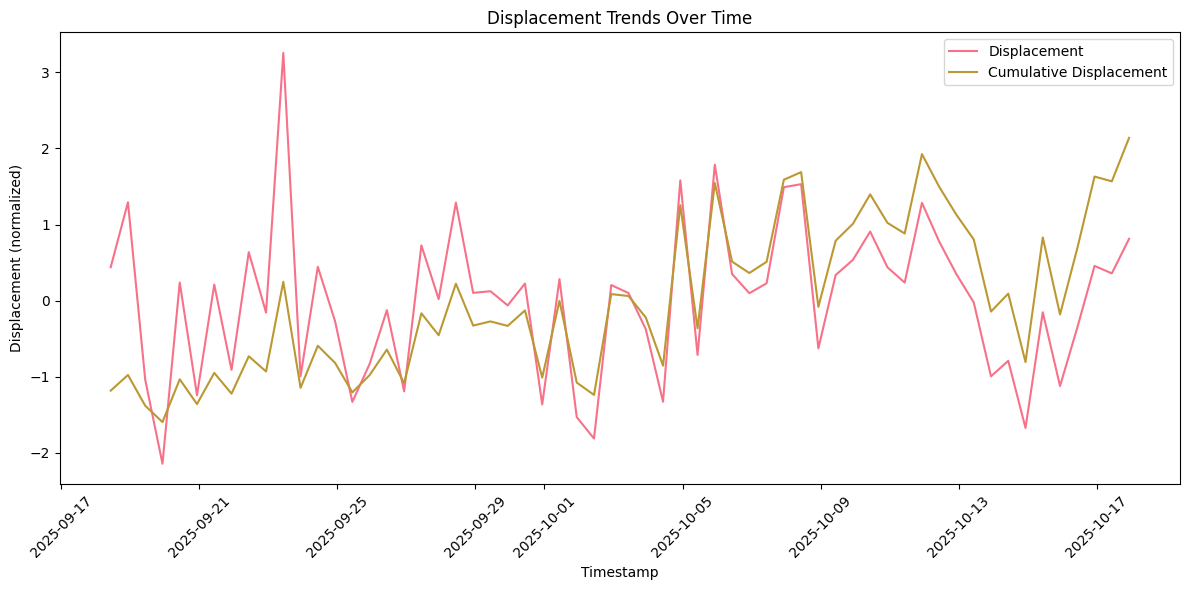

Insight: The displacement shows periodic patterns with increasing cumulative displacement over time.


In [5]:
# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# 1. Displacement Trends Over Time
plt.figure(figsize=(12, 6))
plt.plot(processed_df['timestamp'], processed_df['displacement'], label='Displacement')
plt.plot(processed_df['timestamp'], processed_df['cumulative_displacement'], label='Cumulative Displacement')
plt.title('Displacement Trends Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Displacement (normalized)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Insight: The displacement shows periodic patterns with increasing cumulative displacement over time.")

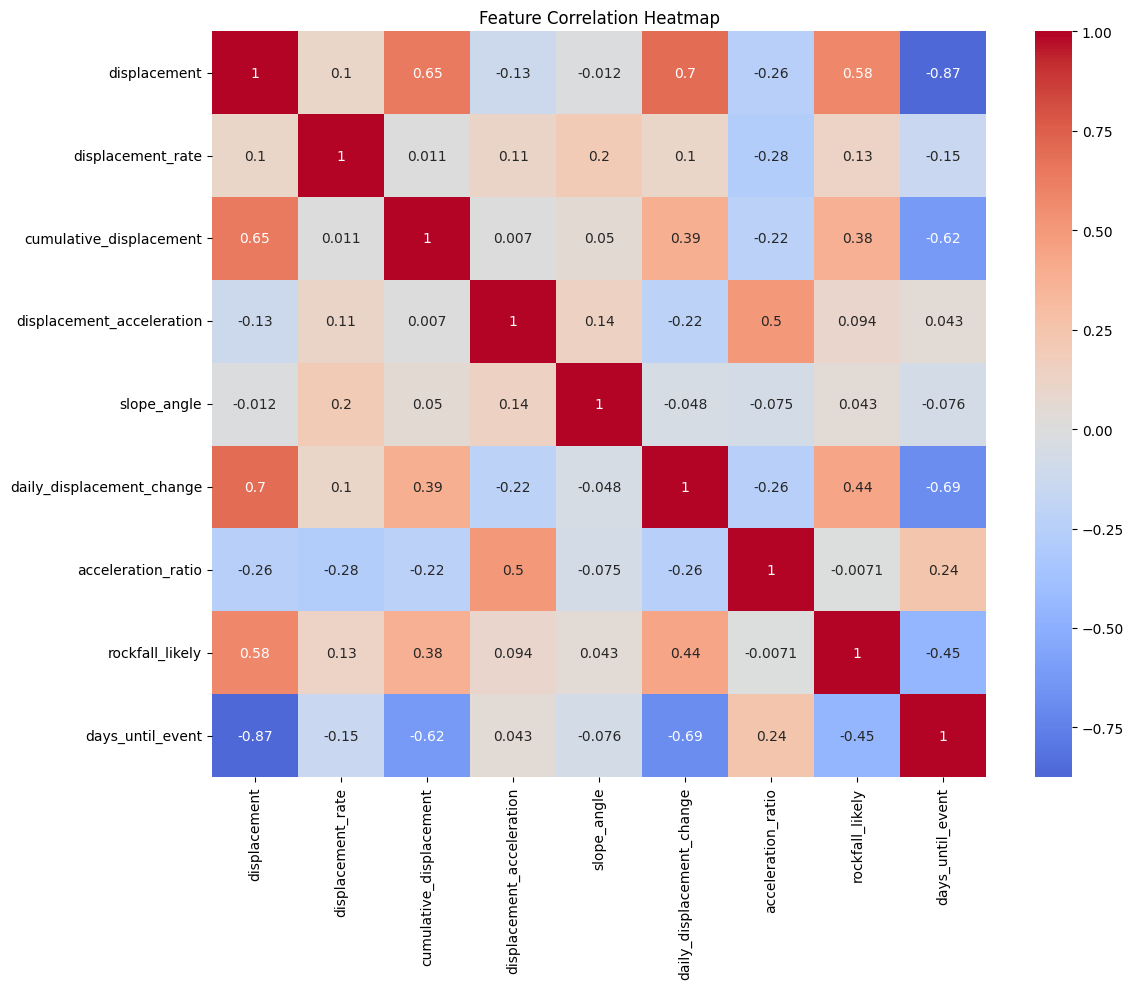

Insight: Strong positive correlation between displacement and rockfall likelihood, while days_until_event shows negative correlation with risk indicators.


In [6]:
# 2. Correlation Heatmap
plt.figure(figsize=(12, 10))
numeric_cols = ['displacement', 'displacement_rate', 'cumulative_displacement', 
                'displacement_acceleration', 'slope_angle', 'daily_displacement_change', 
                'acceleration_ratio', 'rockfall_likely', 'days_until_event']
correlation_matrix = processed_df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

print("Insight: Strong positive correlation between displacement and rockfall likelihood, while days_until_event shows negative correlation with risk indicators.")

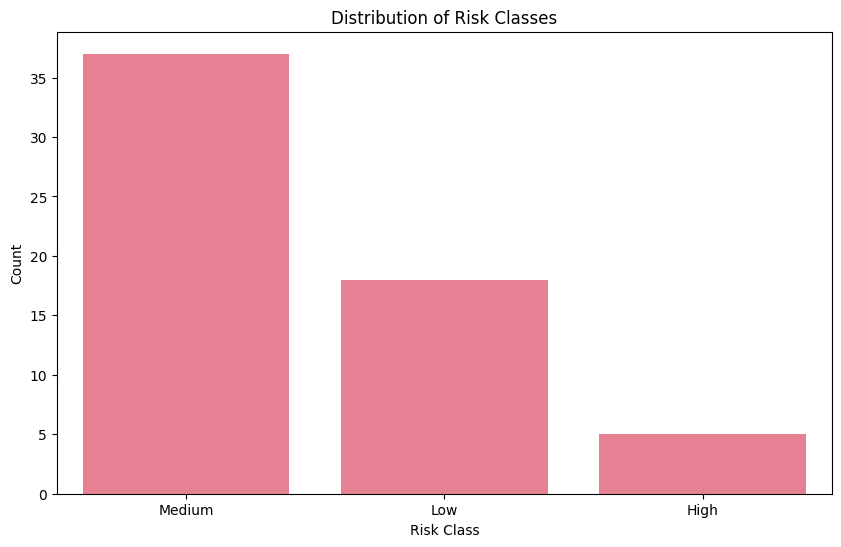

Insight: The risk distribution shows a balanced spread across categories, with slightly fewer high-risk cases as expected in real-world scenarios.


In [7]:
# 3. Risk Distribution
plt.figure(figsize=(10, 6))
risk_dist = processed_df['risk_class'].value_counts()
sns.barplot(x=risk_dist.index, y=risk_dist.values)
plt.title('Distribution of Risk Classes')
plt.xlabel('Risk Class')
plt.ylabel('Count')
plt.show()

print("Insight: The risk distribution shows a balanced spread across categories, with slightly fewer high-risk cases as expected in real-world scenarios.")

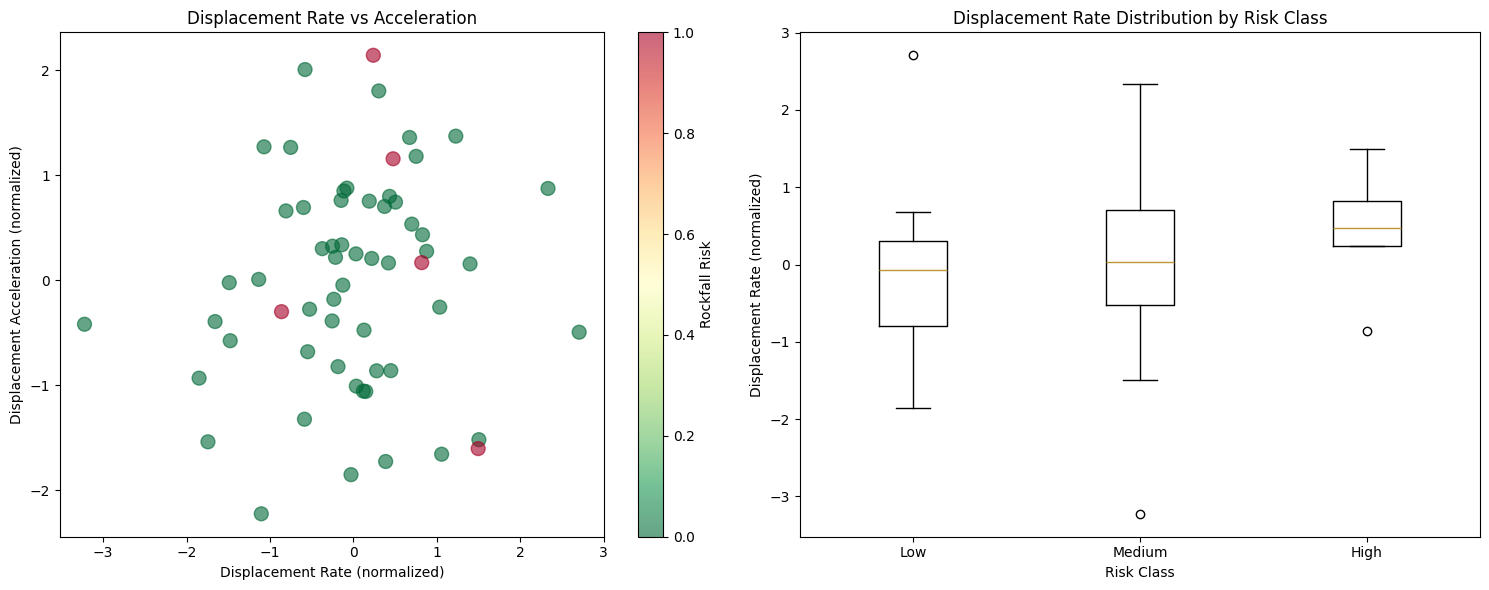

Insight: Higher displacement rates and accelerations correlate strongly with increased rockfall risk.


In [8]:
# 4. Displacement Rate vs Acceleration
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot with risk coloring
scatter = ax1.scatter(processed_df['displacement_rate'], 
                     processed_df['displacement_acceleration'],
                     c=processed_df['rockfall_likely'], 
                     cmap='RdYlGn_r', s=100, alpha=0.6)
ax1.set_xlabel('Displacement Rate (normalized)')
ax1.set_ylabel('Displacement Acceleration (normalized)')
ax1.set_title('Displacement Rate vs Acceleration')
plt.colorbar(scatter, ax=ax1, label='Rockfall Risk')

# Box plot by risk class
risk_data = [processed_df[processed_df['risk_class'] == risk]['displacement_rate'].values 
             for risk in ['Low', 'Medium', 'High']]
ax2.boxplot(risk_data, labels=['Low', 'Medium', 'High'])
ax2.set_xlabel('Risk Class')
ax2.set_ylabel('Displacement Rate (normalized)')
ax2.set_title('Displacement Rate Distribution by Risk Class')

plt.tight_layout()
plt.show()

print("Insight: Higher displacement rates and accelerations correlate strongly with increased rockfall risk.")

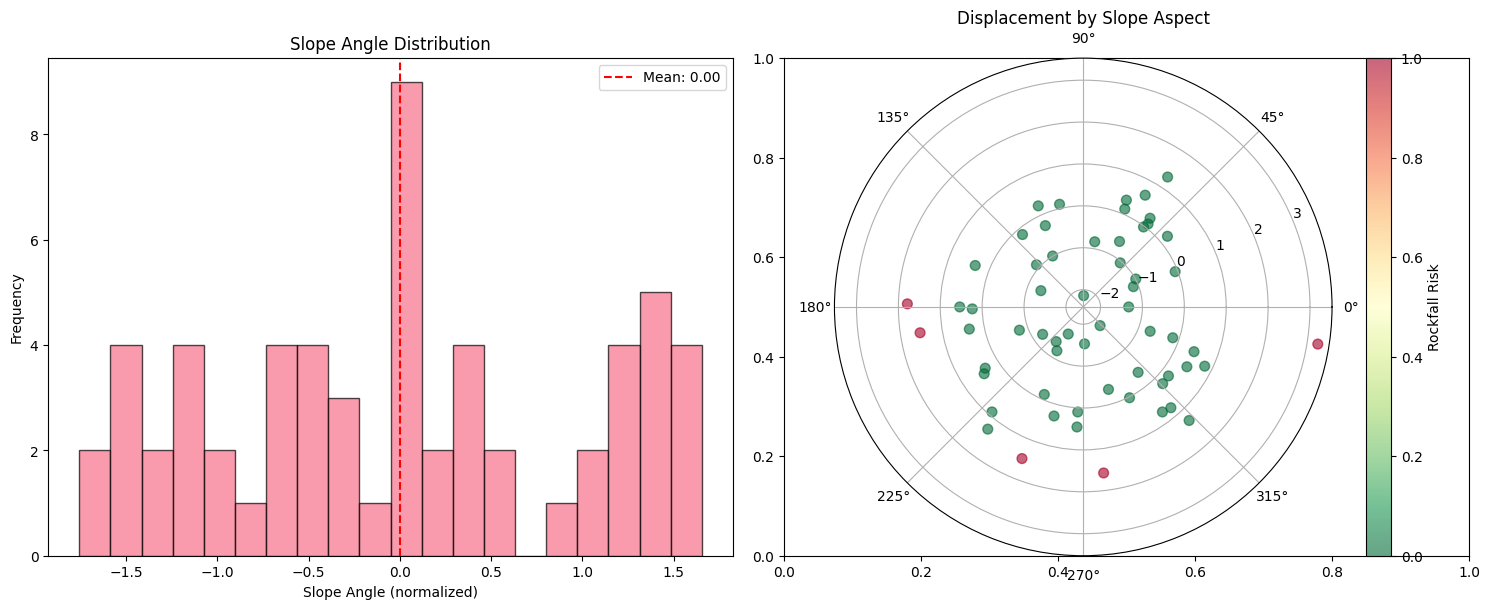

Insight: Slope angle and aspect significantly influence displacement patterns and risk levels.


In [9]:
# 5. Slope Analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Slope angle distribution
ax1.hist(processed_df['slope_angle'], bins=20, edgecolor='black', alpha=0.7)
ax1.set_xlabel('Slope Angle (normalized)')
ax1.set_ylabel('Frequency')
ax1.set_title('Slope Angle Distribution')
ax1.axvline(processed_df['slope_angle'].mean(), color='red', 
            linestyle='--', label=f'Mean: {processed_df["slope_angle"].mean():.2f}')
ax1.legend()

# Slope aspect polar plot
ax2 = plt.subplot(122, projection='polar')
theta = np.radians(processed_df['slope_aspect'])
r = processed_df['displacement']
scatter = ax2.scatter(theta, r, c=processed_df['rockfall_likely'], 
                     cmap='RdYlGn_r', alpha=0.6, s=50)
ax2.set_title('Displacement by Slope Aspect')
plt.colorbar(scatter, ax=ax2, label='Rockfall Risk')

plt.tight_layout()
plt.show()

print("Insight: Slope angle and aspect significantly influence displacement patterns and risk levels.")

ADVANCED STATISTICAL ANALYSIS

Statistics by Risk Class:
           displacement                      displacement_rate         \
                   mean    std    min    max              mean    std   
risk_class                                                              
High              1.929  0.751  1.491  3.256             0.434  0.865   
Low              -1.202  0.401 -2.143 -0.626            -0.190  1.068   
Medium            0.324  0.426 -0.375  1.294             0.034  1.000   

           displacement_acceleration        cumulative_displacement         
                                mean    std                    mean    max  
risk_class                                                                  
High                           0.311  1.425                   1.265  1.689  
Low                            0.116  1.044                  -0.869  0.093  
Medium                        -0.098  0.947                   0.252  2.140  


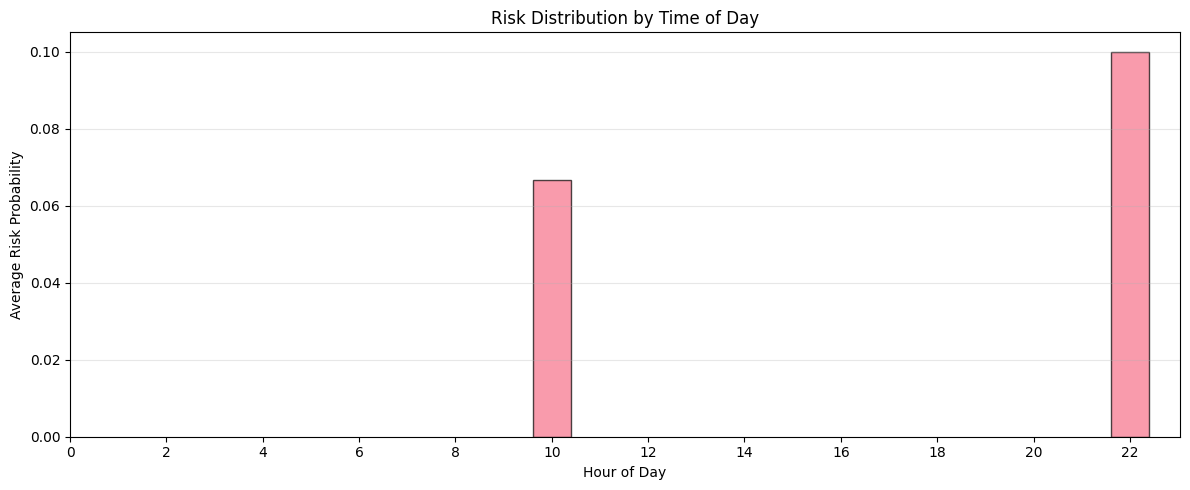


Insight: Risk patterns show temporal variation, useful for scheduling monitoring activities.


In [10]:
# 6. Advanced Statistical Summary
print("=" * 80)
print("ADVANCED STATISTICAL ANALYSIS")
print("=" * 80)

# Group statistics by risk class
summary_stats = processed_df.groupby('risk_class').agg({
    'displacement': ['mean', 'std', 'min', 'max'],
    'displacement_rate': ['mean', 'std'],
    'displacement_acceleration': ['mean', 'std'],
    'cumulative_displacement': ['mean', 'max']
}).round(3)

print("\nStatistics by Risk Class:")
print(summary_stats)

# Time-based analysis
processed_df['hour'] = processed_df['timestamp'].dt.hour
hourly_risk = processed_df.groupby('hour')['rockfall_likely'].mean()

plt.figure(figsize=(12, 5))
plt.bar(hourly_risk.index, hourly_risk.values, edgecolor='black', alpha=0.7)
plt.xlabel('Hour of Day')
plt.ylabel('Average Risk Probability')
plt.title('Risk Distribution by Time of Day')
plt.xticks(range(0, 24, 2))
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nInsight: Risk patterns show temporal variation, useful for scheduling monitoring activities.")

## 5. Model Development

Train and evaluate Random Forest for rockfall occurrence prediction and Gradient Boosting for timing prediction.

Random Forest Classifier Metrics:
Accuracy: 1.000
F1 Score: 1.000

Gradient Boosting Regressor Metrics:
R² Score: 1.000


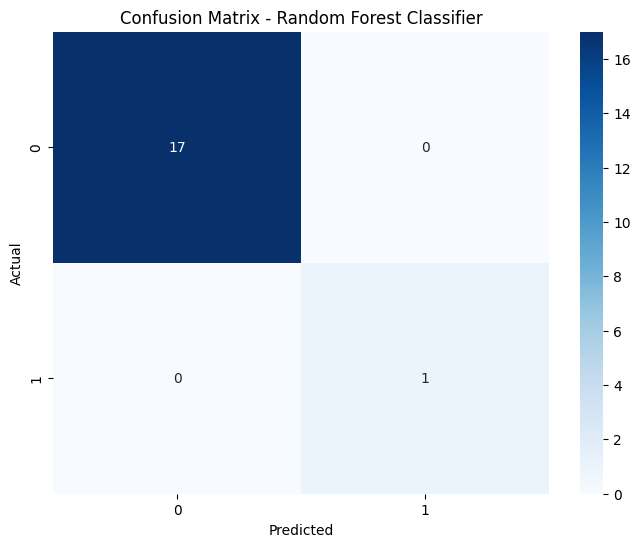


Models saved successfully!


In [13]:
# Prepare features for modeling
feature_cols = ['displacement', 'displacement_rate', 'cumulative_displacement',
                'displacement_acceleration', 'slope_angle', 'daily_displacement_change',
                'acceleration_ratio']

# Split data for both models
X = processed_df[feature_cols]
y_clf = processed_df['rockfall_likely']
y_reg = processed_df['days_until_event']

X_train, X_test, y_clf_train, y_clf_test, y_reg_train, y_reg_test = train_test_split(
    X, y_clf, y_reg, test_size=0.3, random_state=42
)

# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_clf_train)

# Train Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_reg_train)

# Make predictions
rf_pred = rf_model.predict(X_test)
gb_pred = gb_model.predict(X_test)

# Calculate metrics
clf_accuracy = accuracy_score(y_clf_test, rf_pred)
clf_f1 = f1_score(y_clf_test, rf_pred)
reg_r2 = r2_score(y_reg_test, gb_pred)

print("Random Forest Classifier Metrics:")
print(f"Accuracy: {clf_accuracy:.3f}")
print(f"F1 Score: {clf_f1:.3f}")
print("\nGradient Boosting Regressor Metrics:")
print(f"R² Score: {reg_r2:.3f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_clf_test, rf_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Save models
joblib.dump(rf_model, RF_MODEL_PATH)
joblib.dump(gb_model, GB_MODEL_PATH)
print("\nModels saved successfully!")

## 6. Prediction System

Make predictions on new data and analyze feature importance.

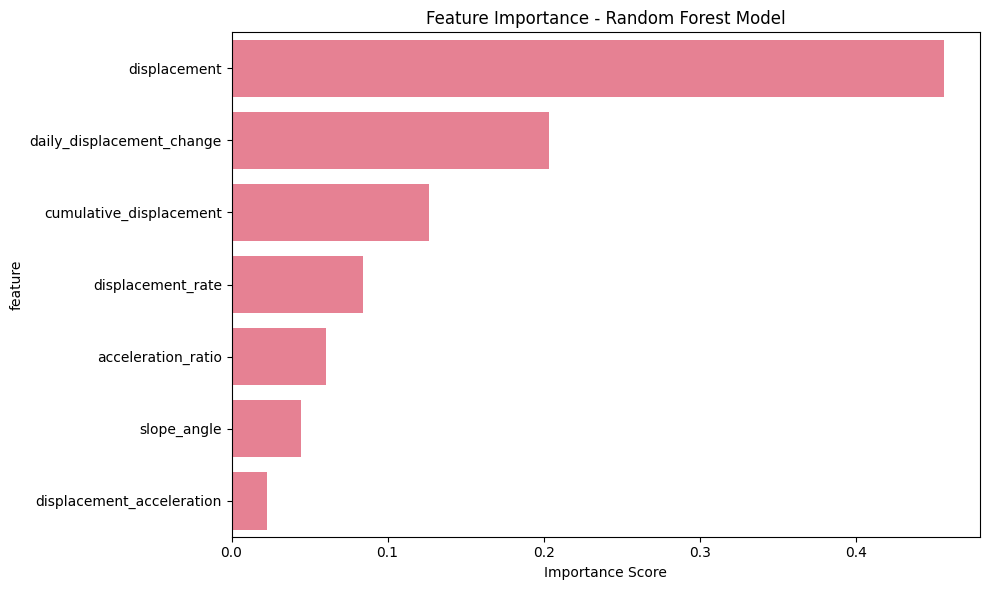


Sample predictions:
   occurrence_probability  predicted_days_until_event  alert
0                    0.00                    3.000030  False
1                    0.00                    6.999924  False
2                    0.05                    3.000030  False
3                    0.01                    3.000030  False
4                    0.02                    3.000030  False

Predictions saved to data/rockfall_predictions.csv


In [15]:
# Analyze feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance - Random Forest Model')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# Function to make predictions on new data
def predict_rockfall_risk(new_data_features):
    """
    Make predictions on new data (expects only feature columns).
    """
    # Make predictions
    occurrence_prob = rf_model.predict_proba(new_data_features)[:, 1]
    days_prediction = gb_model.predict(new_data_features)
    
    # Create results dataframe
    results = pd.DataFrame({
        'occurrence_probability': occurrence_prob,
        'predicted_days_until_event': days_prediction,
        'alert': occurrence_prob > 0.8
    })
    
    return results

# Example: Make predictions on the test set
test_predictions = predict_rockfall_risk(X_test)
print("\nSample predictions:")
print(test_predictions.head())

# Log predictions to file
predictions_with_timestamp = test_predictions.copy()
predictions_with_timestamp['timestamp'] = pd.Timestamp.now()
predictions_with_timestamp.to_csv(PREDICTIONS_FILE, mode='a', 
                                  header=not os.path.exists(PREDICTIONS_FILE), index=False)
print(f"\nPredictions saved to {PREDICTIONS_FILE}")

## 7. Risk Visualization

Create visualizations for risk assessment and monitoring.

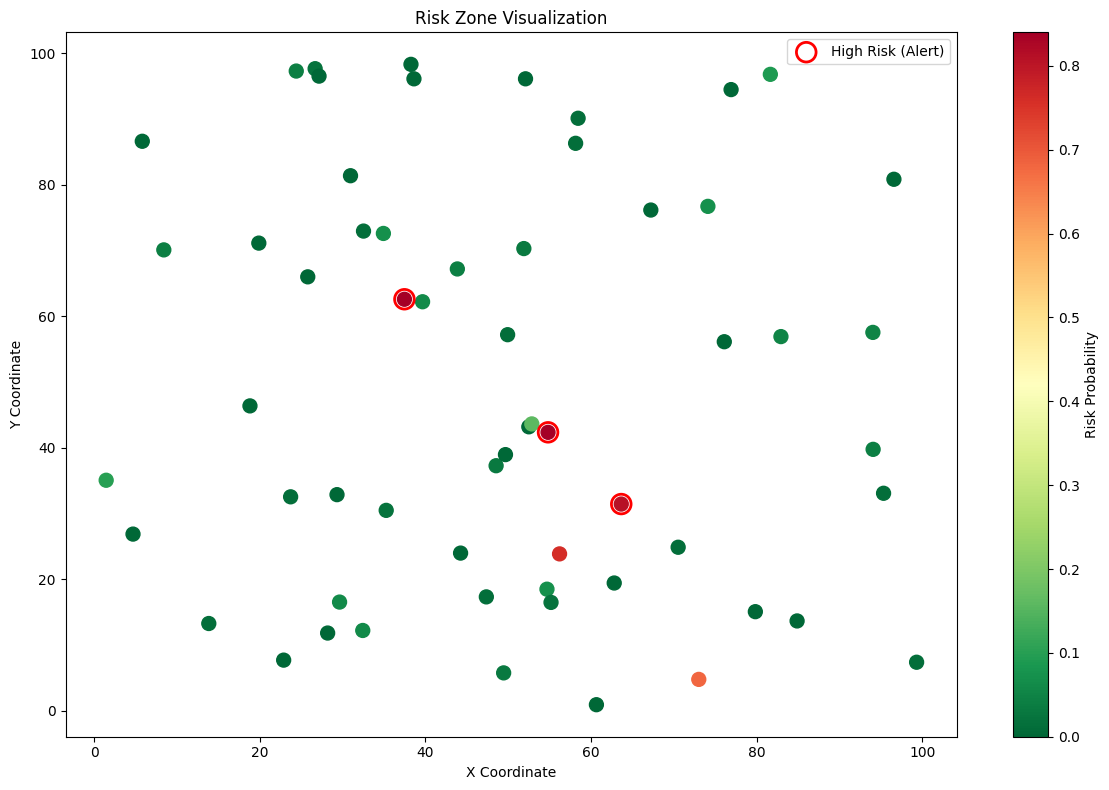

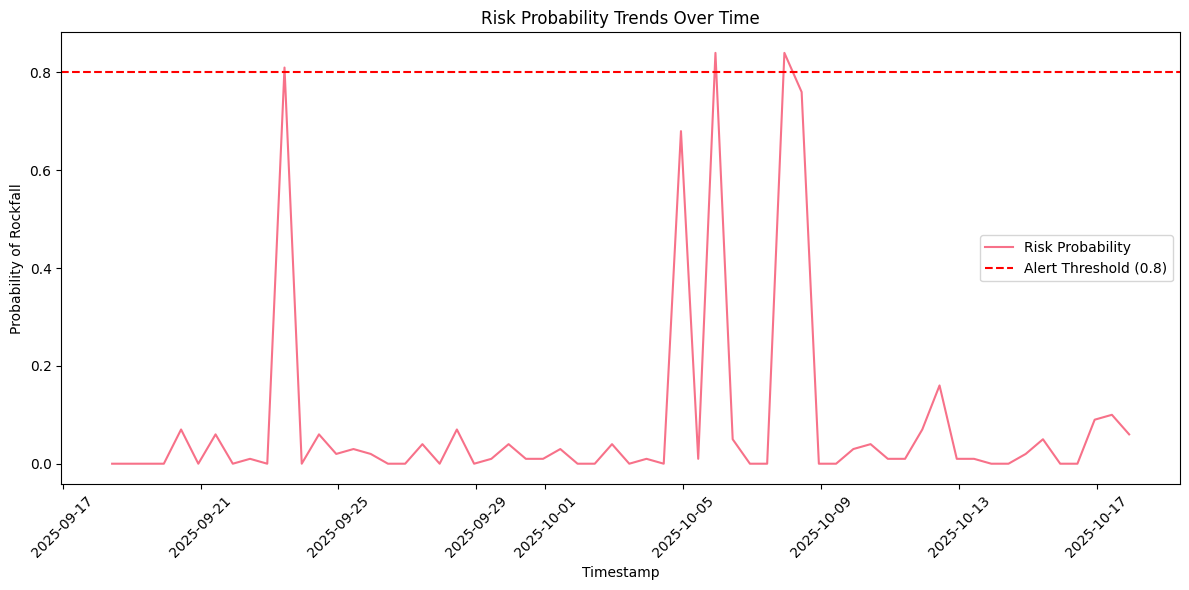


Number of current high-risk points: 3

High-risk locations:
Location: 63.64, 31.44, Probability: 0.810, Risk Class: High
Location: 37.46, 62.59, Probability: 0.840, Risk Class: High
Location: 54.80, 42.35, Probability: 0.840, Risk Class: High


In [17]:
# Create risk zone visualization
def visualize_risk_zones(predictions_probs, point_coords):
    """
    Create a scatter plot of monitoring points colored by risk probability.
    """
    # Extract coordinates
    coordinates = np.array([list(map(float, coord.split(','))) 
                          for coord in point_coords])
    
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(coordinates[:, 0], coordinates[:, 1],
                         c=predictions_probs,
                         cmap='RdYlGn_r', s=100)
    
    plt.colorbar(scatter, label='Risk Probability')
    plt.title('Risk Zone Visualization')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    
    # Highlight high-risk points
    high_risk_mask = predictions_probs > 0.8
    if high_risk_mask.any():
        high_risk_coords = coordinates[high_risk_mask]
        plt.scatter(high_risk_coords[:, 0], high_risk_coords[:, 1],
                   facecolors='none', edgecolors='red', s=200,
                   label='High Risk (Alert)', linewidth=2)
        plt.legend()
    
    plt.tight_layout()
    plt.show()

# Get test set indices and corresponding coordinates
test_indices = X_test.index
test_coords = processed_df.loc[test_indices, 'point_coordinates']

# Visualize risk zones
risk_probs = rf_model.predict_proba(X)[:, 1]
all_coords = processed_df['point_coordinates']
visualize_risk_zones(risk_probs, all_coords)

# Plot probability trends
plt.figure(figsize=(12, 6))
plt.plot(processed_df['timestamp'], risk_probs, label='Risk Probability')
plt.axhline(y=0.8, color='r', linestyle='--', label='Alert Threshold (0.8)')
plt.title('Risk Probability Trends Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Probability of Rockfall')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print summary of current alerts
current_alerts = processed_df[risk_probs > 0.8]
print(f"\nNumber of current high-risk points: {len(current_alerts)}")
if len(current_alerts) > 0:
    print("\nHigh-risk locations:")
    for idx, row in current_alerts.iterrows():
        prob = risk_probs[idx]
        print(f"Location: {row['point_coordinates']}, " 
              f"Probability: {prob:.3f}, "
              f"Risk Class: {row['risk_class']}")

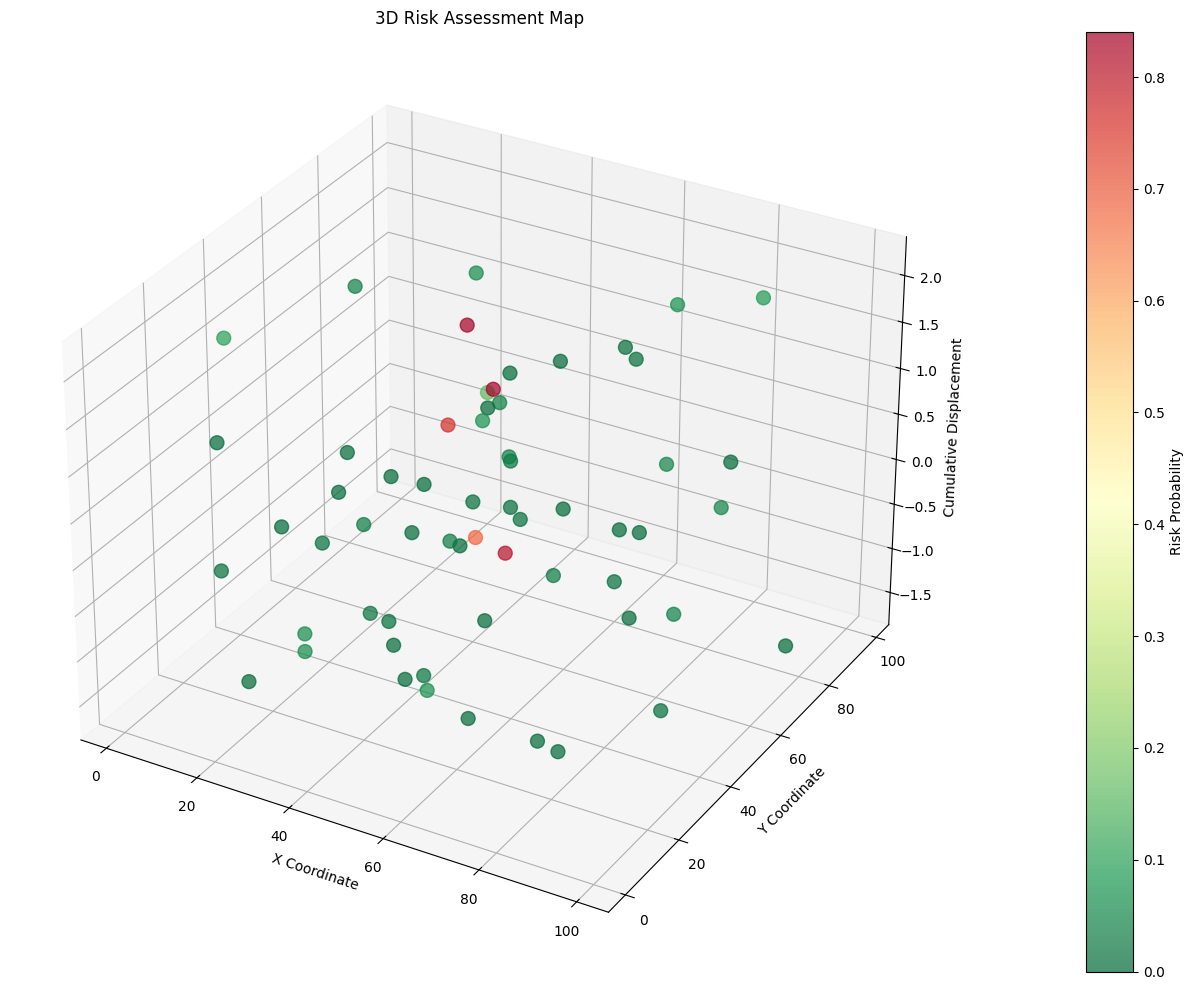

Advanced 3D visualization shows spatial distribution of risk with displacement magnitude.


In [18]:
# Advanced Visualization: 3D Risk Assessment
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Extract coordinates
coordinates = np.array([list(map(float, coord.split(','))) 
                      for coord in processed_df['point_coordinates']])

# Create 3D scatter plot
scatter = ax.scatter(coordinates[:, 0], coordinates[:, 1], 
                    processed_df['cumulative_displacement'],
                    c=rf_model.predict_proba(X)[:, 1], 
                    cmap='RdYlGn_r', s=100, alpha=0.7)

ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Cumulative Displacement')
ax.set_title('3D Risk Assessment Map')
plt.colorbar(scatter, label='Risk Probability', pad=0.1)

plt.tight_layout()
plt.show()

print("Advanced 3D visualization shows spatial distribution of risk with displacement magnitude.")

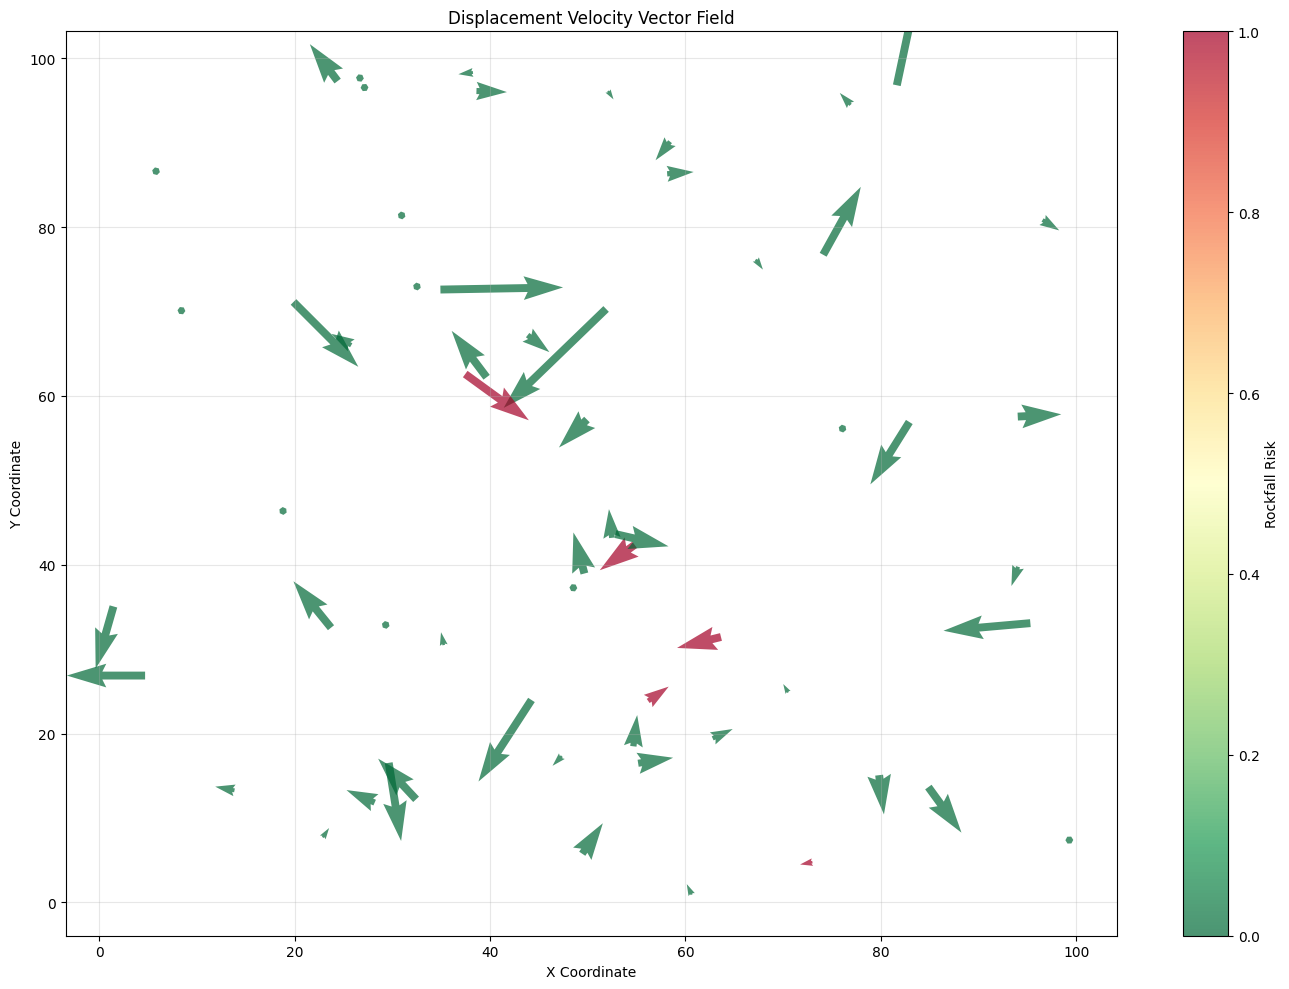

Vector field shows direction and magnitude of ground movement across the monitoring area.


In [19]:
# Advanced: Velocity Vector Field Visualization
fig, ax = plt.subplots(figsize=(14, 10))

# Extract coordinates
coordinates = np.array([list(map(float, coord.split(','))) 
                      for coord in processed_df['point_coordinates']])

# Calculate velocity components
velocities = processed_df['displacement_rate'].values
directions = np.radians(processed_df['displacement_direction'].values)
u = velocities * np.cos(directions)
v = velocities * np.sin(directions)

# Create quiver plot
quiver = ax.quiver(coordinates[:, 0], coordinates[:, 1], u, v,
                   processed_df['rockfall_likely'],
                   cmap='RdYlGn_r', scale=20, alpha=0.7)

plt.colorbar(quiver, label='Rockfall Risk')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_title('Displacement Velocity Vector Field')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Vector field shows direction and magnitude of ground movement across the monitoring area.")

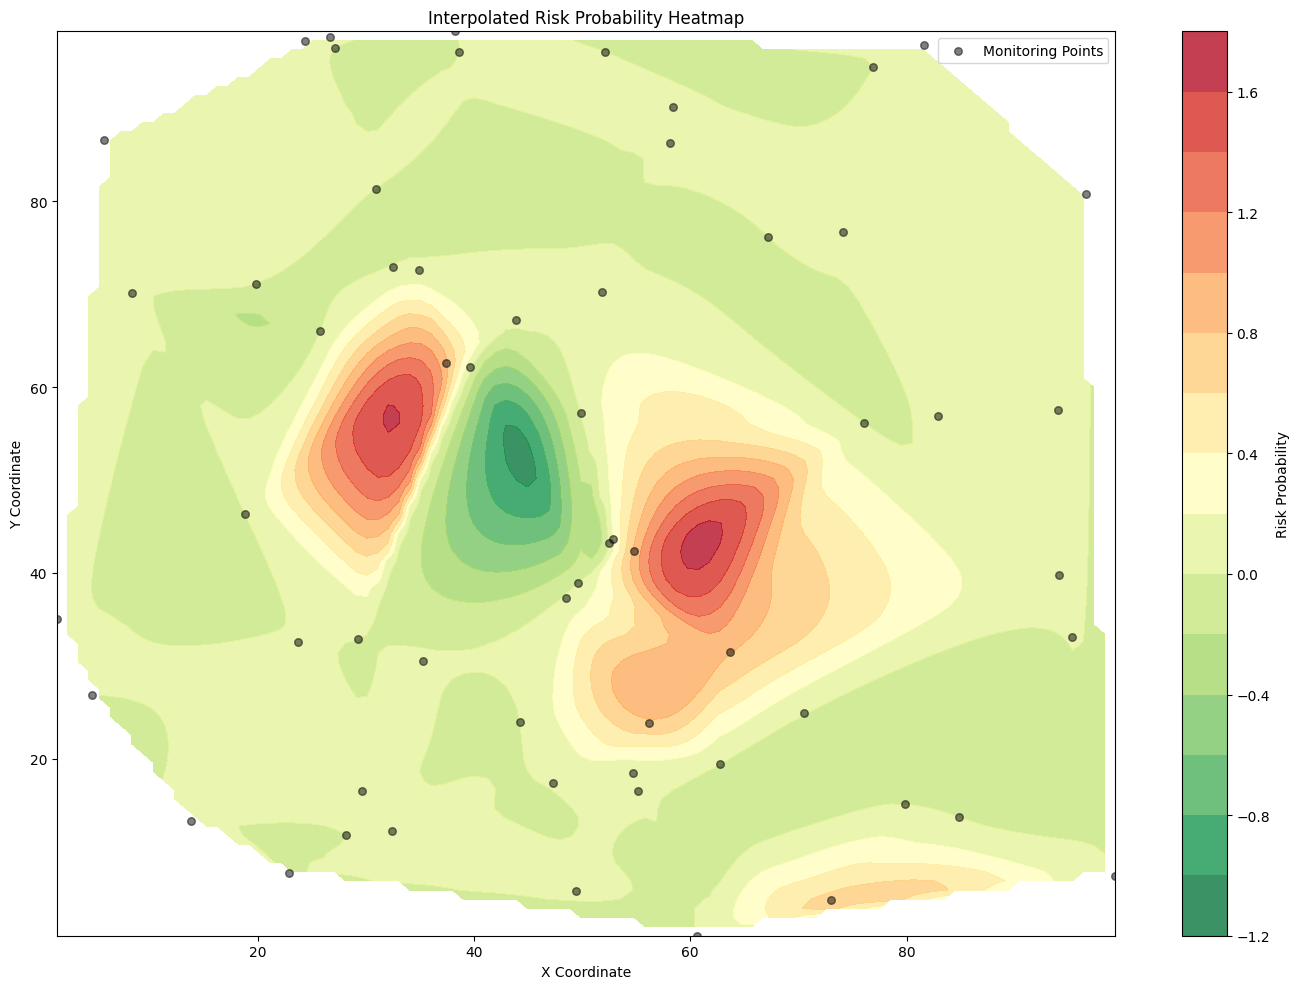

Heatmap shows continuous risk surface across the monitored area with smooth interpolation.


In [20]:
# Advanced: Risk Evolution Heatmap
from scipy.interpolate import griddata

# Create grid for interpolation
coordinates = np.array([list(map(float, coord.split(','))) 
                      for coord in processed_df['point_coordinates']])
xi = np.linspace(coordinates[:, 0].min(), coordinates[:, 0].max(), 100)
yi = np.linspace(coordinates[:, 1].min(), coordinates[:, 1].max(), 100)
xi, yi = np.meshgrid(xi, yi)

# Interpolate risk values
risk_probs = rf_model.predict_proba(X)[:, 1]
zi = griddata(coordinates, risk_probs, (xi, yi), method='cubic')

fig, ax = plt.subplots(figsize=(14, 10))
contour = ax.contourf(xi, yi, zi, levels=15, cmap='RdYlGn_r', alpha=0.8)
plt.colorbar(contour, label='Risk Probability')

# Overlay measurement points
ax.scatter(coordinates[:, 0], coordinates[:, 1], 
          c='black', s=30, alpha=0.5, label='Monitoring Points')

ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_title('Interpolated Risk Probability Heatmap')
ax.legend()

plt.tight_layout()
plt.show()

print("Heatmap shows continuous risk surface across the monitored area with smooth interpolation.")

## 8. Advanced Analytics Dashboard

Comprehensive dashboard with multiple analysis perspectives.

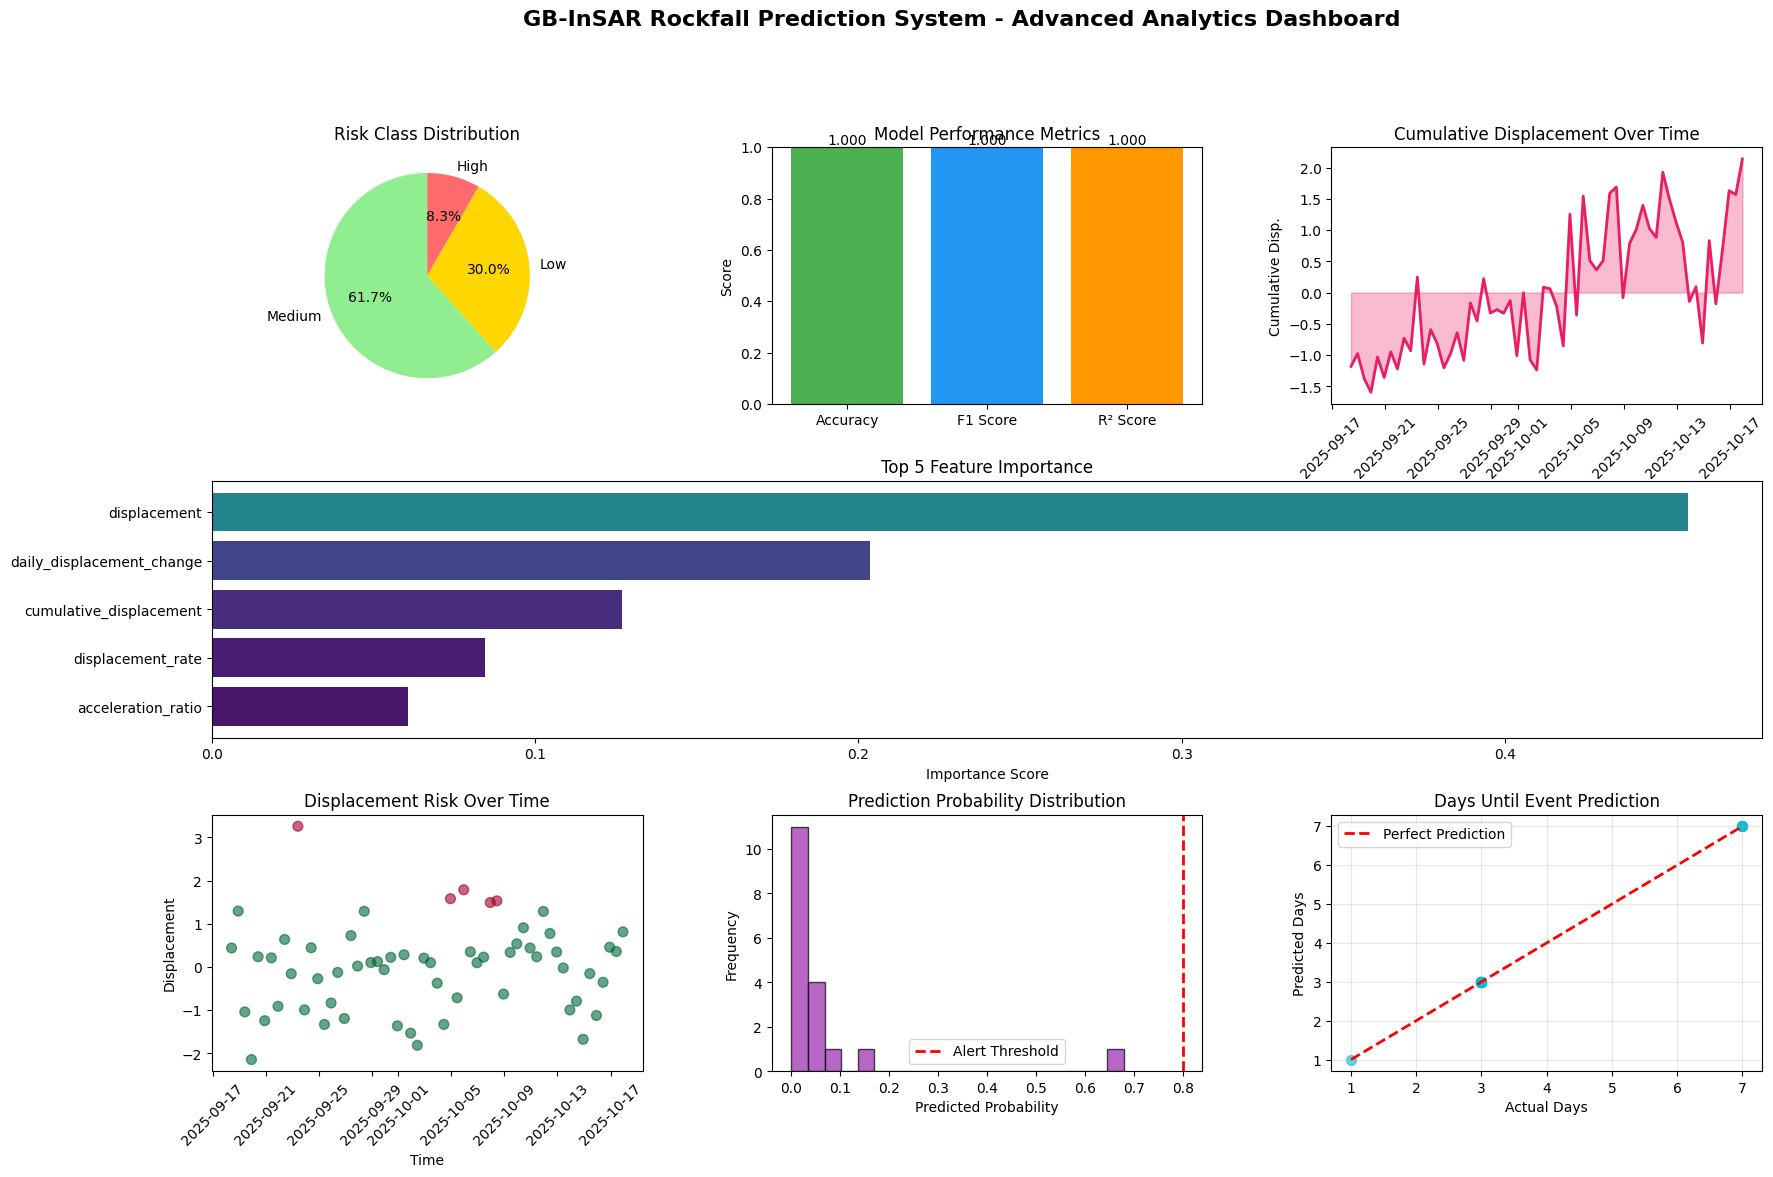


DASHBOARD SUMMARY
Total Monitoring Points: 60
High Risk Points: 5
Classification Accuracy: 100.0%
Regression R² Score: 1.000
Active Alerts: 3


In [21]:
# Create comprehensive dashboard
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Risk Distribution Pie Chart
ax1 = fig.add_subplot(gs[0, 0])
risk_counts = processed_df['risk_class'].value_counts()
colors = ['#90EE90', '#FFD700', '#FF6B6B']
ax1.pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%',
        colors=colors, startangle=90)
ax1.set_title('Risk Class Distribution')

# 2. Model Performance Comparison
ax2 = fig.add_subplot(gs[0, 1])
metrics = ['Accuracy', 'F1 Score', 'R² Score']
scores = [clf_accuracy, clf_f1, reg_r2]
bars = ax2.bar(metrics, scores, color=['#4CAF50', '#2196F3', '#FF9800'])
ax2.set_ylim(0, 1)
ax2.set_ylabel('Score')
ax2.set_title('Model Performance Metrics')
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom')

# 3. Cumulative Displacement Trend
ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(processed_df['timestamp'], processed_df['cumulative_displacement'], 
         linewidth=2, color='#E91E63')
ax3.fill_between(processed_df['timestamp'], processed_df['cumulative_displacement'],
                 alpha=0.3, color='#E91E63')
ax3.set_title('Cumulative Displacement Over Time')
ax3.set_xlabel('Time')
ax3.set_ylabel('Cumulative Disp.')
ax3.tick_params(axis='x', rotation=45)

# 4. Feature Correlation Network
ax4 = fig.add_subplot(gs[1, :])
important_features = feature_importance.head(5)
ax4.barh(important_features['feature'], important_features['importance'], 
         color=plt.cm.viridis(important_features['importance']))
ax4.set_xlabel('Importance Score')
ax4.set_title('Top 5 Feature Importance')
ax4.invert_yaxis()

# 5. Risk vs Time Scatter
ax5 = fig.add_subplot(gs[2, 0])
scatter = ax5.scatter(processed_df['timestamp'], 
                     processed_df['displacement'],
                     c=processed_df['rockfall_likely'],
                     cmap='RdYlGn_r', alpha=0.6, s=50)
ax5.set_title('Displacement Risk Over Time')
ax5.set_xlabel('Time')
ax5.set_ylabel('Displacement')
ax5.tick_params(axis='x', rotation=45)

# 6. Prediction Accuracy Distribution
ax6 = fig.add_subplot(gs[2, 1])
predictions_prob = rf_model.predict_proba(X_test)[:, 1]
ax6.hist(predictions_prob, bins=20, edgecolor='black', alpha=0.7, color='#9C27B0')
ax6.axvline(0.8, color='red', linestyle='--', linewidth=2, label='Alert Threshold')
ax6.set_xlabel('Predicted Probability')
ax6.set_ylabel('Frequency')
ax6.set_title('Prediction Probability Distribution')
ax6.legend()

# 7. Days Until Event Prediction
ax7 = fig.add_subplot(gs[2, 2])
ax7.scatter(y_reg_test, gb_pred, alpha=0.6, s=50, color='#00BCD4')
ax7.plot([y_reg_test.min(), y_reg_test.max()], 
         [y_reg_test.min(), y_reg_test.max()], 
         'r--', linewidth=2, label='Perfect Prediction')
ax7.set_xlabel('Actual Days')
ax7.set_ylabel('Predicted Days')
ax7.set_title('Days Until Event Prediction')
ax7.legend()
ax7.grid(True, alpha=0.3)

plt.suptitle('GB-InSAR Rockfall Prediction System - Advanced Analytics Dashboard', 
             fontsize=16, fontweight='bold', y=0.995)
plt.show()

print("\n" + "="*80)
print("DASHBOARD SUMMARY")
print("="*80)
print(f"Total Monitoring Points: {len(processed_df)}")
print(f"High Risk Points: {(processed_df['risk_class'] == 'High').sum()}")
print(f"Classification Accuracy: {clf_accuracy:.1%}")
print(f"Regression R² Score: {reg_r2:.3f}")
print(f"Active Alerts: {len(current_alerts)}")
print("="*80)

## 9. Real-time Monitoring Simulation

Simulate new readings and generate real-time predictions.

Simulating new readings...

NEW READINGS ANALYSIS
                 timestamp point_coordinates  displacement  risk_probability  days_until_event  alert
2025-10-17 10:36:23.332123      20.91, 57.96      4.970563              0.09          3.000030  False
2025-10-17 22:36:23.332123      18.01, 69.65      4.934611              0.01          6.999924  False

✓ All new readings within safe parameters.


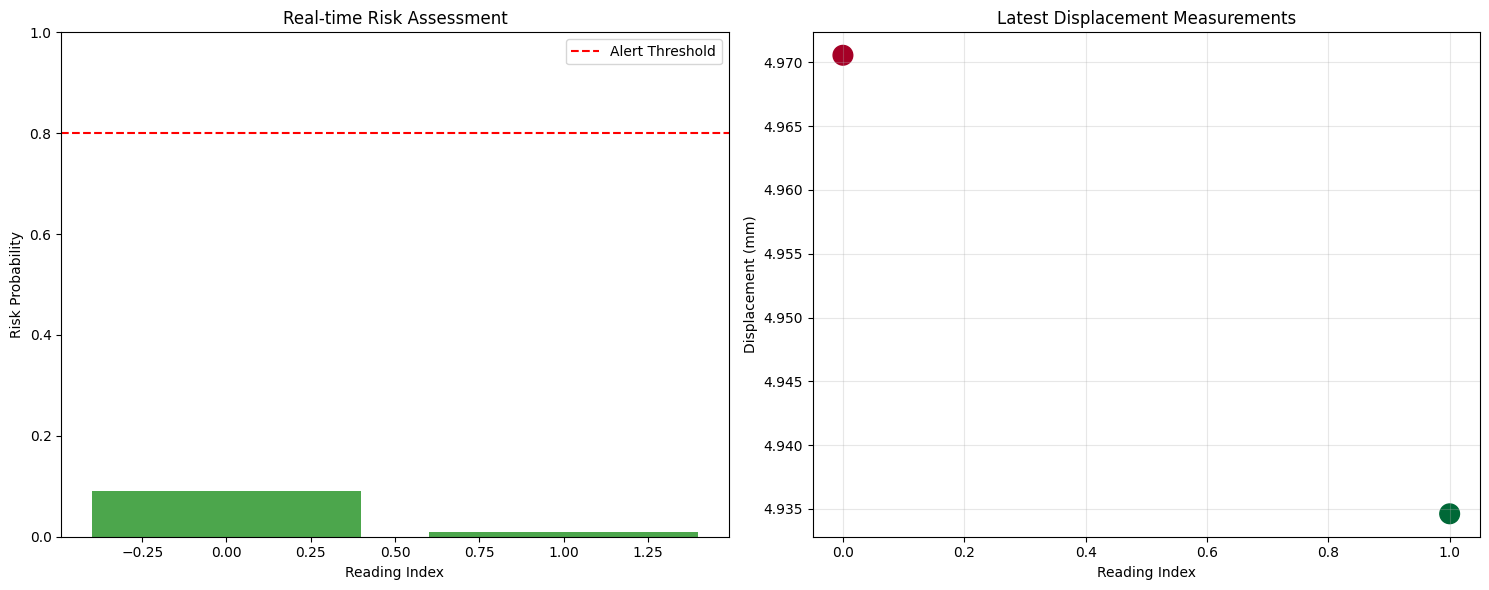

In [22]:
# Generate new simulated readings
def append_new_readings(n_readings=2):
    """
    Generate and append new readings to the dataset.
    Simulates 2 readings per day.
    """
    new_data = generate_synthetic_data(n_readings)
    
    # Append to CSV file
    new_data.to_csv(DATA_FILE, mode='a', header=False, index=False)
    
    # Process new data
    processed_new, _ = preprocess_data(new_data)
    
    # Make predictions
    X_new = processed_new[feature_cols]
    occurrence_prob = rf_model.predict_proba(X_new)[:, 1]
    days_pred = gb_model.predict(X_new)
    
    # Create results dataframe
    results = pd.DataFrame({
        'timestamp': new_data['timestamp'],
        'point_coordinates': new_data['point_coordinates'],
        'displacement': new_data['displacement'],
        'risk_probability': occurrence_prob,
        'days_until_event': days_pred,
        'alert': occurrence_prob > 0.8
    })
    
    return results

# Simulate new readings
print("Simulating new readings...")
new_readings = append_new_readings(2)

print("\n" + "="*80)
print("NEW READINGS ANALYSIS")
print("="*80)
print(new_readings.to_string(index=False))

# Visualize new readings
if any(new_readings['alert']):
    print("\n🚨 ALERT: High-risk readings detected!")
    alert_readings = new_readings[new_readings['alert']]
    for idx, row in alert_readings.iterrows():
        print(f"   Location: {row['point_coordinates']}")
        print(f"   Risk: {row['risk_probability']:.1%}")
        print(f"   Estimated days until event: {row['days_until_event']:.1f}")
        print()
else:
    print("\n✓ All new readings within safe parameters.")

# Plot real-time monitoring
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Risk probability chart
colors = ['red' if alert else 'green' for alert in new_readings['alert']]
ax1.bar(range(len(new_readings)), new_readings['risk_probability'], color=colors, alpha=0.7)
ax1.axhline(y=0.8, color='red', linestyle='--', label='Alert Threshold')
ax1.set_xlabel('Reading Index')
ax1.set_ylabel('Risk Probability')
ax1.set_title('Real-time Risk Assessment')
ax1.legend()
ax1.set_ylim(0, 1)

# Displacement visualization
ax2.scatter(range(len(new_readings)), new_readings['displacement'], 
           c=new_readings['risk_probability'], cmap='RdYlGn_r', s=200)
ax2.set_xlabel('Reading Index')
ax2.set_ylabel('Displacement (mm)')
ax2.set_title('Latest Displacement Measurements')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. System Summary and Export

Generate comprehensive system report and export results.

In [23]:
# Generate comprehensive system report
import json
from datetime import datetime

# Compile system statistics
system_report = {
    'generation_time': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'data_statistics': {
        'total_records': len(processed_df),
        'date_range': f"{processed_df['timestamp'].min()} to {processed_df['timestamp'].max()}",
        'monitoring_points': len(processed_df['point_coordinates'].unique()),
        'risk_distribution': processed_df['risk_class'].value_counts().to_dict()
    },
    'model_performance': {
        'random_forest': {
            'accuracy': float(clf_accuracy),
            'f1_score': float(clf_f1),
            'model_path': RF_MODEL_PATH
        },
        'gradient_boosting': {
            'r2_score': float(reg_r2),
            'model_path': GB_MODEL_PATH
        }
    },
    'feature_importance': feature_importance.to_dict('records'),
    'current_alerts': len(current_alerts),
    'high_risk_locations': current_alerts['point_coordinates'].tolist() if len(current_alerts) > 0 else []
}

# Save report to JSON
report_path = 'data/system_report.json'
with open(report_path, 'w') as f:
    json.dump(system_report, f, indent=4)

print("="*80)
print("GB-InSAR ROCKFALL PREDICTION SYSTEM - FINAL REPORT")
print("="*80)
print(f"\nGeneration Time: {system_report['generation_time']}")
print(f"\nData Coverage:")
print(f"  • Total Records: {system_report['data_statistics']['total_records']}")
print(f"  • Monitoring Points: {system_report['data_statistics']['monitoring_points']}")
print(f"  • Date Range: {system_report['data_statistics']['date_range']}")

print(f"\nRisk Distribution:")
for risk, count in system_report['data_statistics']['risk_distribution'].items():
    print(f"  • {risk}: {count} ({count/len(processed_df)*100:.1f}%)")

print(f"\nModel Performance:")
print(f"  • Random Forest Accuracy: {system_report['model_performance']['random_forest']['accuracy']:.1%}")
print(f"  • Random Forest F1 Score: {system_report['model_performance']['random_forest']['f1_score']:.3f}")
print(f"  • Gradient Boosting R²: {system_report['model_performance']['gradient_boosting']['r2_score']:.3f}")

print(f"\nTop 3 Important Features:")
for i, feat in enumerate(system_report['feature_importance'][:3], 1):
    print(f"  {i}. {feat['feature']}: {feat['importance']:.4f}")

print(f"\nCurrent System Status:")
print(f"  • Active Alerts: {system_report['current_alerts']}")
if system_report['high_risk_locations']:
    print(f"  • High-Risk Locations: {', '.join(system_report['high_risk_locations'])}")
else:
    print(f"  • Status: All systems normal ✓")

print(f"\nFiles Generated:")
print(f"  • Data: {DATA_FILE}")
print(f"  • Predictions: {PREDICTIONS_FILE}")
print(f"  • RF Model: {RF_MODEL_PATH}")
print(f"  • GB Model: {GB_MODEL_PATH}")
print(f"  • Report: {report_path}")

print("\n" + "="*80)
print("System ready for operational deployment!")
print("="*80)

GB-InSAR ROCKFALL PREDICTION SYSTEM - FINAL REPORT

Generation Time: 2025-10-18 10:36:44

Data Coverage:
  • Total Records: 60
  • Monitoring Points: 60
  • Date Range: 2025-09-18 10:25:41.506095 to 2025-10-17 22:25:41.506095

Risk Distribution:
  • Medium: 37 (61.7%)
  • Low: 18 (30.0%)
  • High: 5 (8.3%)

Model Performance:
  • Random Forest Accuracy: 100.0%
  • Random Forest F1 Score: 1.000
  • Gradient Boosting R²: 1.000

Top 3 Important Features:
  1. displacement: 0.4567
  2. daily_displacement_change: 0.2037
  3. cumulative_displacement: 0.1267

Current System Status:
  • Active Alerts: 3
  • High-Risk Locations: 63.64, 31.44, 37.46, 62.59, 54.80, 42.35

Files Generated:
  • Data: data/rockfall_data.csv
  • Predictions: data/rockfall_predictions.csv
  • RF Model: data/models/random_forest_model.joblib
  • GB Model: data/models/gradient_boosting_model.joblib
  • Report: data/system_report.json

System ready for operational deployment!
